This is Stefan's jupyter notebook to explore the data.

In [23]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import re

In [12]:
def load_data():
    with numpy.load("../../data/train_data_label.npz") as data:
        train_data = data["train_data"]
        train_label = data["train_label"]
    
    with numpy.load("../../data/test_data_label.npz") as data:
        test_data = data["test_data"]
        test_label = data["test_label"]

    return train_data, train_label, test_data, test_label

In [13]:
X_train, y_train, X_test, y_test = load_data()

In [14]:
def plot_n_images(data, i = 1):
    d = data[:i]
    for i in range(len(d)):
        plt.imshow(d[i].reshape(28,28), cmap="gray")
        plt.show()

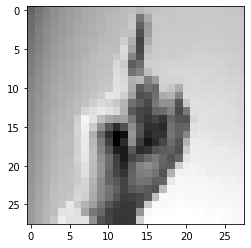

In [15]:
plot_n_images(X_train, 1)

In [16]:
numpy.set_printoptions(formatter = {"int": "{:^4}".format})
print(X_train[0].reshape((28, 28)))

[[107  118  127  134  139  143  146  150  153  156  158  160  163  165
  159  166  168  170  170  171  171  171  172  171  171  170  170  169 ]
 [111  121  129  135  141  144  148  151  154  157  160  163  164  170
  119  152  171  171  170  171  172  172  172  172  172  171  171  170 ]
 [113  123  131  137  142  145  150  152  155  158  161  163  164  172
  105  142  170  171  171  171  172  172  173  173  172  171  171  171 ]
 [116  125  133  139  143  146  151  153  156  159  162  163  167  167
   95  144  171  172  172  172  172  172  173  173  173  172  172  171 ]
 [117  126  134  140  145  149  153  156  158  161  163  164  175  156
   87  154  172  173  173  173  173  173  174  174  174  173  172  172 ]
 [119  128  136  142  146  150  153  156  159  163  165  164  184  148
   89  164  172  174  174  174  174  175  175  174  175  174  173  173 ]
 [122  130  138  143  147  150  154  158  162  165  166  172  181  128
   94  170  173  175  174  175  176  177  177  177  177  175  175

What the images seem to have in common, is that most hand are centered. However, oftentimes the background also has different scales.
- Idea: Try to focus on the hand
    - Use PCA to focus on most important features
- Question: What happens if we standardize and normalize the features?

In [17]:
# Build pipeline to transform the data
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [20]:
# Create different pipelines
pipe_scale_svc = [("scale", StandardScaler()), ("svc", SVC())]
pipe_scale_pca095_svc = [("scale", StandardScaler()), ("reduce_dim", PCA(.95)), ("svc", SVC())]
pipe_scale_pca090_svc = [("scale", StandardScaler()), ("reduce_dim", PCA(.91)), ("svc", SVC())]
pipe_scale_pca085_svc = [("scale", StandardScaler()), ("reduce_dim", PCA(.90)), ("svc", SVC())]
pipe_scale_pca080_svc = [("scale", StandardScaler()), ("reduce_dim", PCA(.89)), ("svc", SVC())]

pipelines = [pipe_scale_svc, pipe_scale_pca095_svc, pipe_scale_pca090_svc, pipe_scale_pca085_svc, pipe_scale_pca080_svc]

In [26]:
# Implementing Gridsearch for PCA
pipe_scale_cvpca_svc = [
    ("scale", StandardScaler()), 
    ("reduce_dim", GridSearchCV(PCA(), param_grid={'n_components': [0.88,0.96]}, cv=10, refit=True)), 
    ("svc", SVC())]
pipelines = [pipe_scale_cvpca_svc]

In [27]:
df = pd.DataFrame(columns = ["pipe", "PCA", "score", "predictions"])
for i, item in enumerate(pipelines):
    pipe = Pipeline(item)
    pipe.fit(X_train, y_train)
    df.loc[i] = [
        str(item),
        re.findall("\d.\d\d", str(item[1])),
        pipe.score(X_test, y_test), 
        pipe.predict(X_test)
    ]

In [25]:
df

,pipe,PCA,score,predictions
0,"[('scale', StandardScaler()), ('reduce_dim', G...","[0.88, 0.95]",0.863776,"[6, 5, 10, 0, 3, 22, 10, 14, 3, 7, 8, 8, 17, 1..."


GridSearchCV(cv=5, estimator=PCA(), param_grid={'n_components': [0.88, 0.96]})

In [84]:
accuracy_score(y_test, preds)

0.8863636363636364

In [67]:
scores

[0.848856664807585, 0.8637757947573899, 0.8863636363636364]

In [42]:
pipe.score(X_test, y_test)

0.848856664807585

# Playground

In [30]:
# Playing with Standard Scaler
scaler = StandardScaler()
print("Maximum Element of first image before scaling:\n", numpy.argmax(X_train[0]))
print()
scaled = scaler.fit_transform(X_train)
print()
print("Maximum Element of first image after scaling:\n", numpy.argmax(scaled[0]))
print()
print("Elements at position [0][0]]: {} and {}".format(X_train[0][0], scaled[0][0]))
print()
print("Shape: {} and {}".format(X_train.shape, scaled.shape))

Maximum Element of first image before scaling:
 747


Maximum Element of first image after scaling:
 771

Elements at position [0][0]]: 107 and -0.9289511341278324

Shape: (27455, 784) and (27455, 784)


In [13]:
# Playing with PCA
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(X_train)

In [14]:
variance_explained = numpy.cumsum(pca.explained_variance_ratio_)
variance_explained[:10]

array([0.31167222, 0.40773116, 0.48461618, 0.5355837 , 0.56824148,
       0.59923932, 0.62649838, 0.65012867, 0.67218756, 0.68939589])

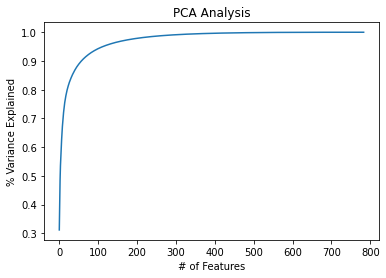

In [16]:
plt.ylabel("% Variance Explained")
plt.xlabel("# of Features")
plt.title("PCA Analysis")
plt.style.context("seaborn-whitegrid")
plt.plot(variance_explained)

In [18]:
# Playing with PCA, where 95% is explained
from sklearn.decomposition import PCA
pca = PCA(.95)
principalComponents = pca.fit_transform(X_train)

variance_explained = numpy.cumsum(pca.explained_variance_ratio_)
variance_explained[:10]

array([0.31167222, 0.40773116, 0.48461618, 0.5355837 , 0.56824148,
       0.59923932, 0.62649838, 0.65012867, 0.67218756, 0.68939589])

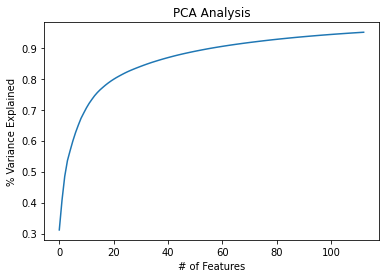

In [19]:
plt.ylabel("% Variance Explained")
plt.xlabel("# of Features")
plt.title("PCA Analysis")
plt.style.context("seaborn-whitegrid")
plt.plot(variance_explained)

In [28]:
print("95 percent of the variance is explained by {} components.".format(len(pca.components_)))

95 percent of the variance is explained by 113 components.


In [251]:
# What about PCA for scaled data?
from sklearn.decomposition import PCA
pca = PCA(.85)
principalComponents = pca.fit_transform(X_train)
variance_explained = numpy.cumsum(pca.explained_variance_ratio_)
variance_explained[:10]

array([0.31167222, 0.40773116, 0.48461618, 0.5355837 , 0.56824148,
       0.59923932, 0.62649838, 0.65012867, 0.67218756, 0.68939589])

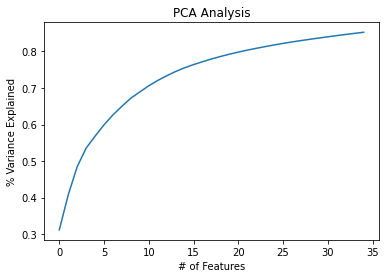

In [252]:
plt.ylabel("% Variance Explained")
plt.xlabel("# of Features")
plt.title("PCA Analysis")
plt.style.context("seaborn-whitegrid")
plt.plot(variance_explained)

In [253]:
print("85 percent of the variance is explained by {} features.".format(len(pca.components_)))

90 percent of the variance is explained by 35 features.
